In [24]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import fixed_portfolio
from src import goals_based_portfolio as gbp
importlib.reload(fixed_portfolio)
importlib.reload(gbp)

<module 'src.goals_based_portfolio' from '/Users/K/works/git/decumulation2/src/goals_based_portfolio.py'>

In [2]:
# 各資産の年率期待リターン
mu_assets = {
    "asset0": 1.43*1e-02,
    "asset1": 5.19*1e-02,
    "asset2": 3.46*1e-02,
    "asset3": 0.86*1e-02,
    "asset4": 5.95*1e-02,
    "asset5": 2.67*1e-02,
    "asset6": 5.84*1e-02,
    "asset7": 7.28*1e-02,
    "asset8": 0,
}
# 各資産の年率期待リスク
sig_assets = {
    "asset0": np.sqrt(2.36*1e-02),
    "asset1": np.sqrt(14.60*1e-02),
    "asset2": np.sqrt(7.48*1e-02),
    "asset3": np.sqrt(4.75*1e-02),
    "asset4": np.sqrt(17.13*1e-02),
    "asset5": np.sqrt(14.45*1e-02),
    "asset6": np.sqrt(14.46*1e-02),
    "asset7": np.sqrt(18.99*1e-02),
    "asset8": 0,
}

In [3]:
# 各リスク許容度RTごとのポートフォリオのボラティリティと期待リターンとアロケーション
weights = pd.DataFrame()
weights["RT"] = np.arange(0, 10, 1)
weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
weights["E[r]"] = [0.0001, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

In [133]:
# ---- Simulation helpers ----
def annual_to_period_params(mu_a: float, sig_a: float, periods_per_year: int, model: str = "gaussian"):
    P = periods_per_year
    if model == "gaussian":
        mu_p = mu_a / P
        sig_p = sig_a / np.sqrt(P)
        return mu_p, sig_p
    elif model == "gbm":
        mu_log_p = np.log(1.0 + mu_a) / P
        sig_log_p = sig_a / np.sqrt(P)
        return mu_log_p, sig_log_p
    else:
        raise ValueError("model must be 'gaussian' or 'gbm'")

def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", model="gaussian", corr=None, seed=42):
    rng = np.random.default_rng(seed)
    assets = list(mu_dict.keys())
    n = len(assets)
    if freq == "M":
        P = 12
    elif freq == "W":
        P = 52
    elif freq == "D":
        P = 252
    else:
        raise ValueError("freq must be one of 'M', 'W', 'D'")

    if corr is None:
        R = np.eye(n)
    else:
        R = corr.reindex(index=assets, columns=assets).to_numpy()

    if model == "gaussian":
        mu_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[0] for a in assets])
        sig_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[1] for a in assets])
        D = np.diag(sig_p)
        cov = D @ R @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
    else:
        mu_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[0] for a in assets])
        sig_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[1] for a in assets])
        D = np.diag(sig_log_p)
        cov_log = D @ R @ D
        eps = rng.multivariate_normal(mean=np.zeros(n), cov=cov_log, size=n_periods)
        rets = np.exp(mu_log_p + eps) - 1.0

    idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
    df = pd.DataFrame(rets, index=idx, columns=assets)
    return df

# ---- Run a default simulation (monthly, 10 years = 120 periods) ----
#df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", model="gaussian", corr=None, seed=123)
df_returns = simulate_returns(mu_assets, sig_assets, n_periods=2000, freq="M", model="gaussian", corr=None, seed=321)  # longer pool

In [198]:
# ブートストラップ法でリサンプリング
def bootstrap(rets, n_steps):
    return rets.sample(n_steps, replace=True).values

In [ ]:
INIT_VAL = 100
WITHDRAWAL_RATE = 0.03 / 12 # per month
RT = 9
N_STEPS = 12 * 35 # month
N_PATHS = 300
AGE = np.arange(65, 100+1/12, 1/12)

rets = bootstrap(df_returns, n_steps=N_STEPS)

In [256]:
model = fixed_portfolio.FixedPortfolio(weights)

In [257]:
S, _, _ = model.run(
    rets=rets,
    init_rt=RT,
    init_val=INIT_VAL,
    contribution=0,
    withdrawal=0,
    const=True
)

In [258]:
W_LOSS = 30.0
W_TARGET = W_LOSS + 10.0   # success requires finishing ≥ 40
P_REQ = 0.90

# Fit policy
policy = gbp.fit_dynamic_policy_for_plan_rt(
    model=model, 
    df_returns=df_returns, #pd.DataFrame(rets, columns=df_returns.columns), #
    weights=weights, plan_rt=RT,
    init_val=INIT_VAL, n_steps=N_STEPS,
    W_target=W_TARGET, W_loss=W_LOSS, p_loss_req=P_REQ,
    const=True, cfg=gbp.DPCfg(sims=150, n_grid=90, lambda_hi=40.0, max_bisect=10, log_margin_hi=0.6),
    seed=20250916
)

In [259]:
S_dyn, rt_path, record_withdrawal = gbp.run_const_dynamic_with_returns(
    model=model, weights=weights, policy=policy, init_val=INIT_VAL, rets_path=rets, const=True
)

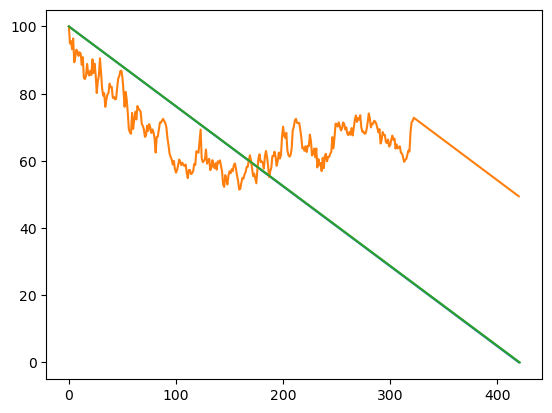

In [260]:
plt.plot(S)
plt.plot(S_dyn)
plt.plot(model.scenario)
plt.show()

#plt.plot(model.record_withdrawals)
#plt.plot(record_withdrawal)
#plt.show()

In [261]:
S_fix_all = np.zeros((N_PATHS, N_STEPS+1))
succ_fix = np.zeros(N_STEPS, dtype=bool)
surv_fix = np.zeros(N_STEPS, dtype=bool)

S_fix_scaling_all = np.zeros((N_PATHS, N_STEPS+1))
succ_fix_scaling = np.zeros(N_STEPS, dtype=bool)
surv_fix_scaling = np.zeros(N_STEPS, dtype=bool)

S_dyn_all = np.zeros((N_PATHS, N_STEPS+1))
succ_dyn = np.zeros(N_STEPS, dtype=bool)
surv_dyn = np.zeros(N_STEPS, dtype=bool)

for b in range(N_PATHS):
    rets = bootstrap(df_returns, n_steps=N_STEPS)

    S_fix, _, _ = model.run(
        rets=rets,
        init_rt=RT,
        init_val=INIT_VAL,
        contribution=0.0,
        withdrawal=0.0,
        const=True
    )
    S_fix_all[b] = S_fix
    succ_fix[b] = (S_fix[-1] >= W_TARGET)
    surv_fix[b] = np.all(S_fix >= W_LOSS)
    
    S_dyn, rt_path, record_withdrawal = gbp.run_const_dynamic_with_returns(
        model=model, 
        weights=weights, 
        policy=policy, 
        init_val=INIT_VAL, 
        rets_path=rets, 
        const=True
    )
    S_dyn_all[b] = S_dyn
    succ_dyn[b] = (S_dyn[-1] >= W_TARGET)
    surv_dyn[b] = np.all(S_dyn >= W_LOSS)

    S_fix_scaling, _, _ = model.run(
        rets=rets,
        init_rt=RT,
        init_val=INIT_VAL,
        contribution=0.0,
        withdrawal=0.0,
        const=False
    )
    S_fix_scaling_all[b] = S_fix_scaling
    succ_fix_scaling[b] = (S_fix_scaling[-1] >= W_TARGET)
    surv_fix_scaling[b] = np.all(S_fix_scaling >= W_LOSS)


In [262]:
summary = pd.DataFrame({
    "metric": ["success_prob (W_T>=40)", "survival_prob (min W_t>=30)", "E[W_T]"],
    "Fixed_RT": [float(np.mean(succ_fix)), float(np.mean(surv_fix)), float(np.mean(S_fix_all[:, -1]))],
    "Fixed_Scaling_RT": [float(np.mean(succ_fix_scaling)), float(np.mean(surv_fix_scaling)), float(np.mean(S_fix_scaling_all[:, -1]))],
    "Dnamic_RT": [float(np.mean(succ_dyn)), float(np.mean(surv_dyn)), float(np.mean(S_dyn_all[:, -1]))],
})
summary

,metric,Fixed_RT,Fixed_Scaling_RT,Dnamic_RT
0,success_prob (W_T>=40),0.000000,0.000000,0.480952
1,survival_prob (min W_t>=30),0.000000,0.000000,0.459524
2,E[W_T],0.062011,0.237101,41.728500


In [263]:
def summarize(vals):
    return {
        "mean": float(np.mean(vals)),
        "p05": float(np.percentile(vals, 5)),
        "p25": float(np.percentile(vals, 25)),
        "p50": float(np.percentile(vals, 50)),
        "p75": float(np.percentile(vals, 75)),
        "p95": float(np.percentile(vals, 95)),
        "min": float(np.min(vals)),
        "max": float(np.max(vals)),
    }

tw_fix = summarize(S_fix_all[:, -1])
tw_fix_scaling = summarize(S_fix_scaling_all[:, -1])
tw_dyn = summarize(S_dyn_all[:, -1])
tw_df = pd.DataFrame([
    {"model":"Fixed_RT", **tw_fix}, 
    {"model":"Fixed_Scaling_RT", **tw_fix_scaling},
    {"model":"Dynamic_RT", **tw_dyn}
])
tw_df


,model,mean,p05,p25,p50,p75,p95,min,max
0,Fixed_RT,0.062011,0.062011,0.062011,0.062011,0.062011,0.062011,0.062011,0.062011
1,Fixed_Scaling_RT,0.237101,0.237101,0.237101,0.237101,0.237101,0.237101,0.237101,0.237101
2,Dynamic_RT,41.728500,0.000000,7.422840,51.699572,63.848641,73.669291,0.000000,83.785040


/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_24202/726583805.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figH.show()


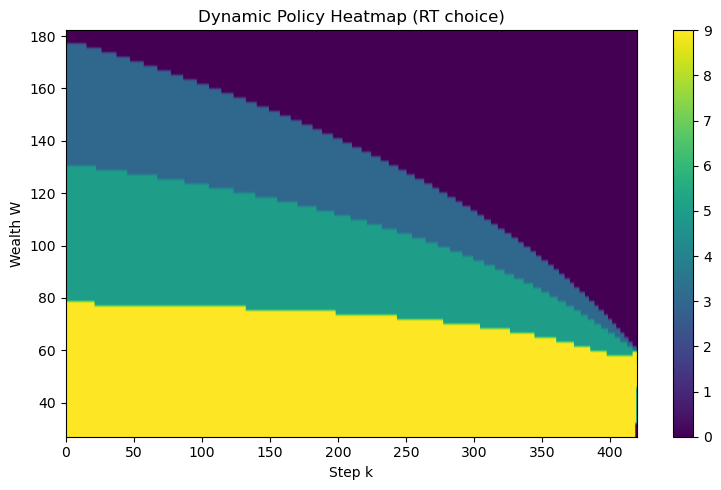

In [264]:
figH = plt.figure(figsize=(8,5))
pol_mat = np.vstack(policy.policy).T  # (n_grid, N)
extent=[0, N_STEPS, policy.grid_w[0], policy.grid_w[-1]]
plt.imshow(pol_mat, aspect="auto", origin="lower", extent=extent)
cbar = plt.colorbar(); cbar.set_ticks(list(weights["RT"].values)); cbar.set_ticklabels([str(int(x)) for x in weights["RT"].values])
plt.xlabel("Step k"); plt.ylabel("Wealth W"); plt.title("Dynamic Policy Heatmap (RT choice)")
figH.tight_layout()
figH.show()